# 0 Imports

In [3]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact

import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

In [20]:
# Constants

# path para guardar o dataset
PATH = './'
PATH_TRAIN_CSV = './data/train.csv'
PATH_TRAIN_IMG = './data/train_data.mat'
PATH_TEST_CSV = './data/test.csv'
PATH_TEST_IMG = './data/test_data.mat'

EPOCHS = 75
BATCH_SIZE = 30
LEARNING_RATE = 0.001

device = torch.device("cuda")

# 1 Exploração e Preparação dos Dados

### Visualização dos dados

In [5]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    return  train_np, test_np


def load_data(path_train_csv, path_train_img, path_test_csv, path_test_img):
    train_csv = pd.read_csv(path_train_csv, header=0)
    test_csv = pd.read_csv(path_test_csv, header=0)
    train_img, test_img = get_data_from_mat(path_train_img, path_test_img)
    return train_csv, test_csv, train_img, test_img


def visualize(image):
    plt.imshow(image, cmap="gray")    
    plt.show()      

def show_ds(ds):
    print("ds shape:",ds.shape)
    print("ds max:",np.max(ds))
    print("ds min:",np.min(ds))
    print("ds average:",np.average(ds))
    @interact
    def visualize_set(scan_index=(0,len(ds)-1)):
        visualize(ds[scan_index,:,:])

In [6]:
train_csv, test_csv, train_img, test_img = load_data(PATH_TRAIN_CSV, PATH_TRAIN_IMG, PATH_TEST_CSV, PATH_TEST_IMG)

print("Data de treino:")
print(train_csv)
show_ds(train_img)
print("Data de Teste:")
print(test_csv)
show_ds(test_img)

Data de treino:
      id  age  sex  education
0      1   13    1          7
1      2   14    0          8
2      3   15    1          9
3      4   15    1          9
4      5   15    1          9
..   ...  ...  ...        ...
107  108   77    1          4
108  109   67    0          4
109  110   55    0          4
110  111   76    1          3
111  112   69    0          4

[112 rows x 4 columns]
ds shape: (112, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024116160549305543


interactive(children=(IntSlider(value=55, description='scan_index', max=111), Output()), _dom_classes=('widget…

Data de Teste:
    id  sex  education
0    1    0         13
1    2    0         11
2    3    1          9
3    4    1         13
4    5    0         12
5    6    0         17
6    7    0          9
7    8    0          4
8    9    1          9
9   10    1          4
10  11    1         14
11  12    0          9
12  13    1          2
13  14    1          5
14  15    1          9
15  16    1         11
16  17    1          9
17  18    0         17
18  19    1         15
19  20    1         14
20  21    1          4
21  22    0          4
22  23    1          4
23  24    0          0
24  25    1          2
25  26    1          4
26  27    1          3
27  28    1          4
ds shape: (28, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024994026906171023


interactive(children=(IntSlider(value=13, description='scan_index', max=27), Output()), _dom_classes=('widget-…

### Preparação dos dados

In [7]:
def fix_sex_id_columns(train_csv, test_csv):
    for csv in [train_csv, test_csv]:
        female = csv['sex']
        male = []
        for person in female:
            if person==1:
                male.append(0)
            else:
                male.append(1)
        csv.drop('sex', axis='columns', inplace=True)
        csv['female']=female
        csv['male']=male
        csv.drop('id', axis='columns', inplace=True)
    return train_csv, test_csv
    
def img_to_list(img):
    tamanho = len(img)
    lista = []
    # triangular inferior sem diagonal
    for linha in range(tamanho):
        for coluna in range(linha):
            lista.append(img[linha][coluna])
    return lista

def imgs_to_matrix(imgs):
    matrix = []
    for img in imgs:
        matrix.append(img_to_list(img))
    return matrix

def join_data(train_csv, test_csv, train_img, test_img):
    train_matrix = imgs_to_matrix(train_img)
    test_matrix = imgs_to_matrix(test_img)
    train_data  = pd.concat([train_csv, pd.DataFrame(train_matrix)], axis=1)
    train_data.columns = list(train_csv.columns) + [f'rel-{i}' for i in range(len(train_matrix[0]))]
    test_data = pd.concat([test_csv, pd.DataFrame(test_matrix)], axis=1)
    test_data.columns = list(test_csv.columns) + [f'rel-{i}' for i in range(len(test_matrix[0]))]
    return train_data , test_data

def remove_non_relations(train_data, test_data):
    for data in [train_data, test_data]:
        data.drop('education', axis='columns', inplace=True)
        data.drop('female', axis='columns', inplace=True)
        data.drop('male', axis='columns', inplace=True)
    return train_data, test_data

def remove_education(train_data, test_data):
    for data in [train_data, test_data]:
        data.drop('education', axis='columns', inplace=True)
    return train_data, test_data

def remove_null_columns(train_data, test_data):
    columns_to_drop = []
    for column_name in test_data.columns:
        if (train_data[column_name] == 0).all() and (test_data[column_name] == 0).all():
            columns_to_drop.append(column_name)

    train_data = train_data.drop(columns_to_drop, axis=1)
    test_data = test_data.drop(columns_to_drop, axis=1)

    return train_data, test_data, columns_to_drop

In [9]:
train_csv, test_csv, train_img, test_img = load_data(PATH_TRAIN_CSV, PATH_TRAIN_IMG, PATH_TEST_CSV, PATH_TEST_IMG)
train_csv_fix, test_csv_fix = fix_sex_id_columns(train_csv, test_csv)

# everything (sex, education, relations)
train_complete_data, test_complete_data = join_data(train_csv_fix, test_csv_fix, train_img, test_img)

print('\nComplete:')
print(train_complete_data.head(1))
print(test_complete_data.head(1))

train_complete_data.to_csv('./processed-data/train_complete_data.csv', index=False)
test_complete_data.to_csv('./processed-data/test_complete_data.csv', index=False)

# without null relations (sex, education, not-null relations)
train_complete_not_null_data, test_complete_not_null_data, unrelated_brain_zones = remove_null_columns(copy.copy(train_complete_data), copy.copy(test_complete_data))

print('\nComplete without null relations:')
print(train_complete_not_null_data.head(1))
print(test_complete_not_null_data.head(1))

print('\nUnrelated brain zones:')
print(unrelated_brain_zones[:50])

train_complete_not_null_data.to_csv('./processed-data/train_complete_not_null_data.csv', index=False)
test_complete_not_null_data.to_csv('./processed-data/test_complete_not_null_data.csv', index=False)

# only sex and not-null relations
train_sex_not_null_data, test_sex_not_null_data = remove_education(copy.copy(train_complete_not_null_data), copy.copy(test_complete_not_null_data))

print('\nOnly sex and without null relations:')
print(train_sex_not_null_data.head(1))
print(test_sex_not_null_data.head(1))

train_sex_not_null_data.to_csv('./processed-data/train_sex_not_null_data.csv', index=False)
test_sex_not_null_data.to_csv('./processed-data/test_sex_not_null_data.csv', index=False)

# only not-null relations
train_relations_not_null_data, test_relations_not_null_data = remove_non_relations(copy.copy(train_complete_not_null_data), copy.copy(test_complete_not_null_data))

print('\nOnly not null relations:')
print(train_relations_not_null_data.head(1))
print(test_relations_not_null_data.head(1))

train_relations_not_null_data.to_csv('./processed-data/train_relations_not_null_data.csv', index=False)
test_relations_not_null_data.to_csv('./processed-data/test_relations_not_null_data.csv', index=False)

# only relations (null and not-null relations)
train_relations_data, test_relations_data = remove_non_relations(copy.copy(train_complete_data), copy.copy(test_complete_data))

print('\nOnly relations:')
print(train_relations_data.head(1))
print(test_relations_data.head(1))

train_relations_data.to_csv('./processed-data/train_relations_data.csv', index=False)
test_relations_data.to_csv('./processed-data/test_relations_data.csv', index=False)


Complete:
   age  education  female  male  rel-0     rel-1  rel-2  rel-3    rel-4   
0   13          7       1     0    0.0  0.131525    0.0    0.0  0.13695  \

   rel-5  ...  rel-3995  rel-3996  rel-3997  rel-3998  rel-3999  rel-4000   
0    0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0  \

   rel-4001  rel-4002  rel-4003  rel-4004  
0  0.585006       0.0  0.280606       0.0  

[1 rows x 4009 columns]
   education  female  male  rel-0     rel-1  rel-2  rel-3     rel-4     rel-5   
0         13       0     1    0.0  0.140891    0.0    0.0  0.158141  0.034232  \

   rel-6  ...  rel-3995  rel-3996  rel-3997  rel-3998  rel-3999  rel-4000   
0    0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0  \

   rel-4001  rel-4002  rel-4003  rel-4004  
0  0.612109       0.0  0.193069       0.0  

[1 rows x 4008 columns]

Complete without null relations:
   age  education  female  male     rel-1  rel-3    rel-4  rel-5     rel-8   
0   13          7       1  

tensor([27., 62., 15., 20., 19., 70., 40., 16., 15., 41., 56., 61., 58., 55.,
        13., 16., 25., 51., 58., 52., 24., 16., 25., 57., 69., 55., 24., 66.,
        62., 58., 15., 46., 27., 17., 18., 53., 68., 54., 71., 15., 77., 69.,
        27., 18., 17., 76., 31., 76., 16., 40., 68., 69., 25., 24., 64., 57.,
        18., 16., 63., 22., 15., 59., 26., 15., 16., 24., 51., 16., 72., 71.,
        63., 18., 20., 69., 24., 68., 56., 67., 55., 19., 53., 42., 58., 65.,
        73., 19., 63., 77., 62., 68.])


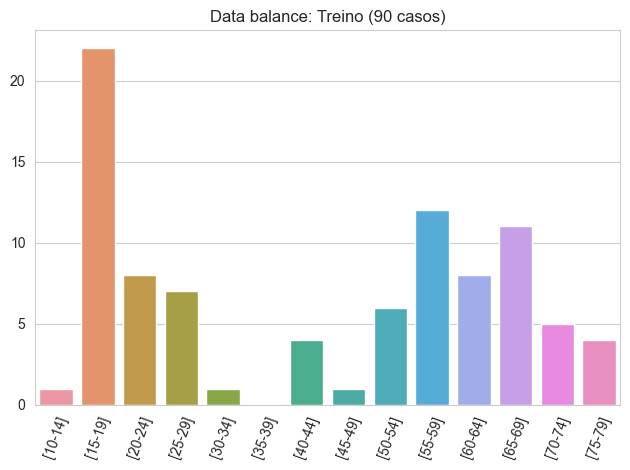

tensor([21., 79., 65., 71., 15., 69., 22., 76., 69., 33., 74., 64., 59., 71.,
        14., 18., 28., 74., 37., 25., 16., 76.])


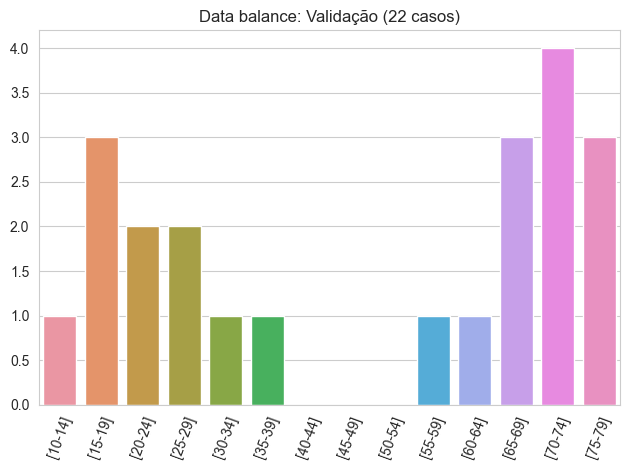

In [ ]:
import math
def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))
    print(labels)
    sns.set_style('whitegrid')
    dic={}
    for i in range(14):
        dic[f'[{10+5*i}-{14+5*i}]']=0
    x, y = np.unique(labels, return_counts=True)
    for i in range(len(x)):
        low = math.floor(x[i] / 5) * 5
        dic[f'[{low}-{low+4}]']+=y[i]
    x_ext = list(dic.keys())
    y_ext = list(dic.values())
    grafico=sns.barplot(x=x_ext, y=y_ext)
    grafico.set_title(f'Data balance: {titulo} ({len(labels)} casos)')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show() 
    
visualize_holdout_balance(train_dl_all, 'Treino')
visualize_holdout_balance(val_dl_all, 'Validação')

# 2 Definir o Modelo

In [39]:
class MLP(Module):
    def __init__(self, num_inputs, num_hidden=[256,128,64]):
        super(MLP, self).__init__()
        #input -> hidden 1
        self.hidden1 = Linear(num_inputs, num_hidden[0] )
        xavier_uniform_(self.hidden1.weight)
        self.act1 = ReLU()
        
        #hidden 1 --> hidden 2
        self.hidden2 = Linear(num_hidden[0],num_hidden[1])
        xavier_uniform_(self.hidden2.weight)
        self.act2 = ReLU()
            
        #hidden 2 --> hidden 3
        self.hidden3 = Linear(num_hidden[1],num_hidden[2])
        xavier_uniform_(self.hidden3.weight)
        self.act3 = ReLU()
        
        #hidden 3 --> output
        self.hidden4 = Linear(num_hidden[2],1)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = ReLU()

    def forward(self, X):
        X = self.hidden1(X) ### input é tranferido para a rede
        X = self.act1(X) ### o resultado da rede vai para a função de ativação
        
        #hidden 1 --> hidden 2
        X = self.hidden2(X)
        X = self.act2(X)
        
        #hidden 2 --> hidden 3
        X = self.hidden3(X)
        X = self.act3(X)
        
        #hidden 3 --> output
        X = self.hidden4(X)
        return X

model = MLP(1205)
print(summary(model, verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            308,736
├─ReLU: 1-2                              --
├─Linear: 1-3                            32,896
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            65
├─ReLU: 1-8                              --
Total params: 349,953
Trainable params: 349,953
Non-trainable params: 0


# 3 Treinar o Modelo

In [40]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {} # para o livelossplot
        # Train phase
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            #acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        # Validation phase
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            #acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        #print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file) # para gravar o modelo no final do treino

In [41]:
# definição classe para o dataset
class CSVDataset(Dataset):
  # ler o dataset
  def __init__(self, dataframe):
    # separar os inputs e os outputs
    self.y = torch.tensor(dataframe['age'].values, dtype=torch.float32)
    self.x = torch.tensor(dataframe.drop(columns='age').values, dtype=torch.float32)
        
  # número de casos no dataset
  def __len__(self):
    return len(self.x)

  # retornar um caso
  def __getitem__(self, idx):
    label = self.y[idx]
    data = self.x[idx]       
    return data, label

def prepare_train_data_loaders(path_train):
  # Split the data into training and validation sets
  df = pd.read_csv(path_train, header=0)
  train_size = 90
  val_size = 22
  train_df = df.sample(n=train_size, random_state=42)
  val_df = df.drop(train_df.index).sample(n=val_size, random_state=42)

  # Extract the underlying DataFrames from the Subset objects
  if isinstance(train_df, Subset):
      train_df = train_df.dataset
  if isinstance(val_df, Subset):
      val_df = val_df.dataset

  # Create the training and validation datasets
  train = CSVDataset(train_df)
  validation = CSVDataset(val_df)

  # Create the training and validation dataloaders
  train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
  val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
  train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
  val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)

  return train_dl, val_dl, train_dl_all, val_dl_all, df.shape[1]-1

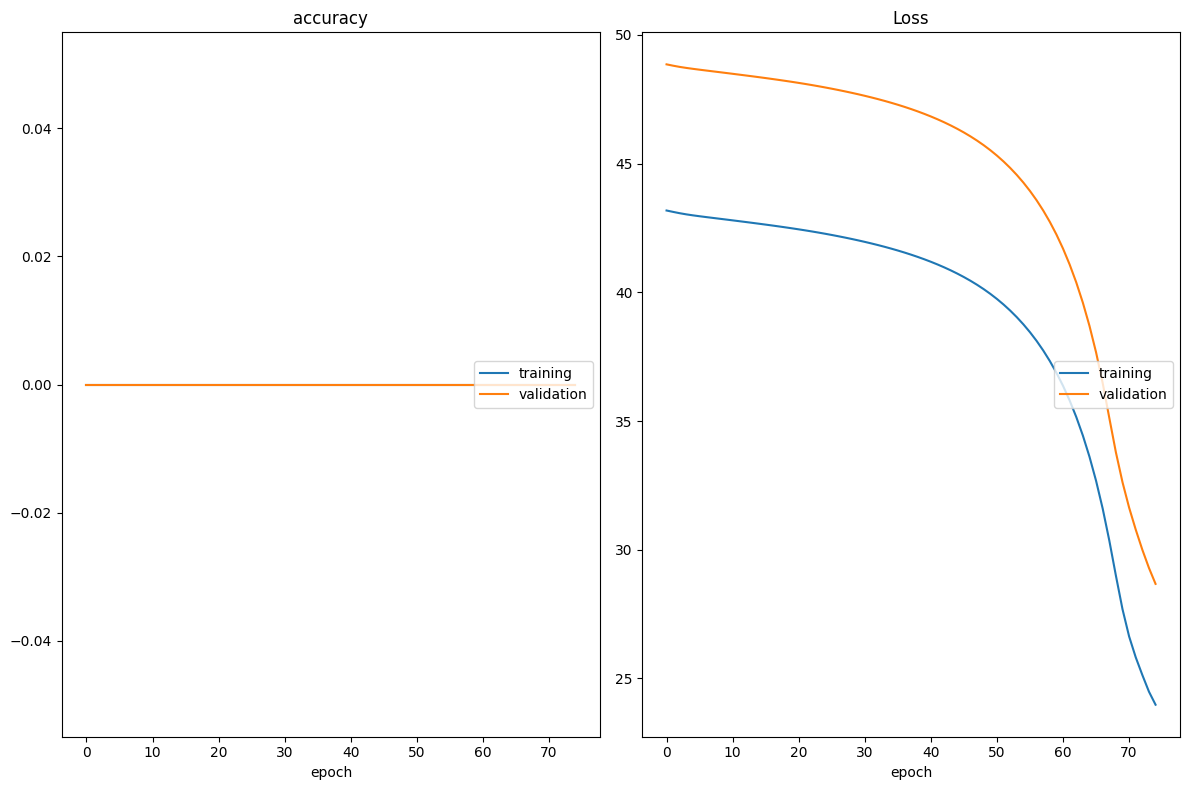

accuracy
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:   23.981, max:   43.176, cur:   23.981)
	validation       	 (min:   28.674, max:   48.852, cur:   28.674)
Tempo gasto: 34.203119100000094 segundos


In [45]:
################ DADOS ################
train_dl, val_dl, train_dl_all, val_dl_all, num = prepare_train_data_loaders('./processed-data/train_relations_data.csv')
####### CNNModelCompleteNotNull #######
model = MLP(num)
model.cuda()
device = torch.device("cuda")


############### TREINAR ###############
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
# optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
starttime = time.perf_counter()
train_model('./models/CNNModelCompleteNotNull.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

# 4 Avaliar o Modelo

# 5 Testar o Modelo

In [43]:
# definição classe para o dataset
class CSVTestDataset(Dataset):
  # ler o dataset
  def __init__(self, dataframe):
    # separar os inputs e os outputs
    self.x = torch.tensor(dataframe.values, dtype=torch.float32)
        
  # número de casos no dataset
  def __len__(self):
    return len(self.x)

  # retornar um caso
  def __getitem__(self, idx):
    data = self.x[idx]       
    return data

def prepare_test_data_loaders(path_train):
  test_df = pd.read_csv(path_train, header=0)

  # Create the training and validation datasets
  test = CSVTestDataset(test_df)

  # Create the training and validation dataloaders
  test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
  test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)

  return test_dl, test_dl_all

In [44]:
####### CNNModelCompleteNotNull #######
test_dl, test_dl_all = prepare_test_data_loaders('./processed-data/test_complete_not_null_data.csv')

model = torch.load('./Models/CNNModelCompleteNotNull.pth')
model.eval()

predictions_ = []

with torch.no_grad():
    for data in test_dl:
        data = data.to(device)
        output = model(data)
        predictions_.extend(output.tolist())

predictions = []
for prediction in predictions_:
    for p in prediction:
        predictions.append(p)

result = pd.read_csv('./data/example_submission.csv')
result['age']=predictions
result.to_csv('./results/res.csv', index=False)